In [1]:
import pandas as pd

# read file with reviews data for restaurants
reviews = pd.read_csv('datasets/reviews_restaurants.csv')

In [2]:
# filter out restaurants with price range of 2
reviews = reviews[reviews['stars'] != 3]

# add categories based on price
reviews['quality'] = ''
reviews.loc[reviews['stars'] <= 2, 'quality'] = 'bad'
reviews.loc[reviews['stars'] >= 4, 'quality'] = 'good'

# check results
reviews.groupby('quality').count()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,price_range,state
quality,,,,,,,,,,,
bad,936313,936313,936313,936313,936313,936313,936313,936313,936313,936313,936313
good,3083250,3083250,3083250,3083250,3083250,3083250,3083250,3083250,3083249,3083250,3083250


In [3]:
# reduce the dataset to 10000 reviews of each category
reviews = reviews.groupby('quality').apply(lambda x: x.sample(10000, random_state=0).reset_index(drop=True))
reviews = reviews.droplevel(level=0)

# check if the sampling went well
reviews.groupby('quality').count()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,price_range,state
quality,,,,,,,,,,,
bad,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
good,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

review_group = reviews['quality'].tolist()
X_train, X_test, y_train, y_test = train_test_split(reviews[['text']], np.array(review_group), test_size=0.25, random_state=0)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [5]:
from text_representation import get_processed_inputs, sum_to_one
from sklearn.feature_extraction.text import CountVectorizer

# pre-process the inputs
bow_train = get_processed_inputs(X_train)

# create the BoW representation for the set
bow_vec = CountVectorizer(max_features=1024, ngram_range=(1,2))
bow_train = sum_to_one(bow_vec.fit_transform(bow_train).toarray())

# we now create vectors for testing and validation
bow_test = sum_to_one(bow_vec.transform(get_processed_inputs(X_test)).toarray())
bow_validation = sum_to_one(bow_vec.transform(get_processed_inputs(X_validation)).toarray())

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# using SVMs for classification
svm = SVC(C=0.5).fit(bow_train, y_train)
print("SVM validation score:", svm.score(bow_validation, y_validation))
print("SVM train score:", svm.score(bow_train, y_train))

# using random forests for classification
rfc = RandomForestClassifier(max_depth=5, random_state=0).fit(bow_train, y_train)
print("RF validation score:", rfc.score(bow_validation, y_validation))
print("RF train score:", rfc.score(bow_train, y_train))

# using logistic regression for classification
lrc = LogisticRegression(random_state=0, max_iter=125, C=0.5).fit(bow_train, y_train)
print("LR validation score:", lrc.score(bow_validation, y_validation))
print("LR train score:", lrc.score(bow_train, y_train))

# using naive bayes for classification
nbc = MultinomialNB().fit(bow_train, y_train)
print("NB validation score:", nbc.score(bow_validation, y_validation))
print("NB train score:", nbc.score(bow_train, y_train))

SVM validation score: 0.9132
SVM train score: 0.9608
RF validation score: 0.866
RF train score: 0.8818666666666667
LR validation score: 0.8752
LR train score: 0.8773333333333333
NB validation score: 0.9048
NB train score: 0.9090666666666667


In [7]:
print("SVM test score:", svm.score(bow_test, y_test))
print("RF test score:", rfc.score(bow_test, y_test))
print("LR test score:", lrc.score(bow_test, y_test))
print("NB test score:", nbc.score(bow_test, y_test))

SVM test score: 0.9272
RF test score: 0.8848
LR test score: 0.886
NB test score: 0.9136


In [8]:
from sklearn.decomposition import PCA
from text_representation import word2vec

# get word2vec embeddings
w2v_train = word2vec(X_train)
w2v_validation = word2vec(X_validation)
w2v_test = word2vec(X_test)

# get PCA embeddings
pca = PCA(n_components=64).fit(bow_train)
pca_train = pca.transform(bow_train)
pca_validation = pca.transform(bow_validation)
pca_test = pca.transform(bow_test)

In [72]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import CosineSimilarity

model = Sequential()
model.add(Dense(1024, input_dim=1024, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1024, activation="sigmoid"))

# compile
model.compile(optimizer='adam', loss=CosineSimilarity(axis=1), metrics=['mse'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_34 (Dense)            (None, 16)                16400     
                                                                 
 dense_35 (Dense)            (None, 1024)              17408     
                                                                 
Total params: 1,083,408
Trainable params: 1,083,408
Non-trainable params: 0
_________________________________________________________________


In [74]:
# train the model for the autoencoder
history = model.fit(bow_train, bow_train, epochs=10, validation_data=(X_test, y_test), verbose=2)

KeyboardInterrupt: 

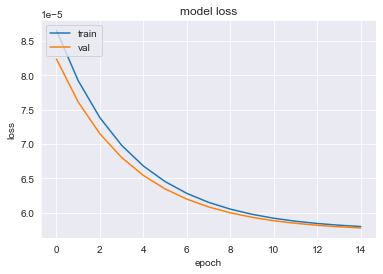

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
import keras.models as models

# reconstruct the autoencoder from a saved file
autoencoder = models.load_model("models/autoencoder_good_bad")

# create a model that only encodes the vectors
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_16').output)

In [49]:
# create a compressed representation for the vectors and check new shape
encoded_train = encoder.predict(np.array(bow_train))
encoded_validation = encoder.predict(np.array(bow_validation))
encoded_test = encoder.predict(np.array(bow_test))
print(encoded_train.shape)

(15000, 16)


In [29]:
# using SVMs for classification
svm = SVC(C=0.5).fit(w2v_train, y_train)
print("SVM validation score:", svm.score(w2v_validation, y_validation))
print("SVM train score:", svm.score(w2v_train, y_train))

# using random forests for classification
rfc = RandomForestClassifier(max_depth=5, random_state=0).fit(w2v_train, y_train)
print("RF validation score:", rfc.score(w2v_validation, y_validation))
print("RF train score:", rfc.score(w2v_train, y_train))

# using logistic regression for classification
lrc = LogisticRegression(random_state=0, max_iter=125, C=0.5).fit(w2v_train, y_train)
print("LR validation score:", lrc.score(w2v_validation, y_validation))
print("LR train score:", lrc.score(w2v_train, y_train))

SVM validation score: 0.9184
SVM train score: 0.9308666666666666
RF validation score: 0.8596
RF train score: 0.8704
LR validation score: 0.9024
LR train score: 0.9142666666666667


ValueError: Negative values in data passed to MultinomialNB (input X)

In [30]:
print("SVM test score:", svm.score(w2v_test, y_test))
print("RF test score:", rfc.score(w2v_test, y_test))
print("LR test score:", lrc.score(w2v_test, y_test))

SVM test score: 0.9232
RF test score: 0.862
LR test score: 0.9196


In [31]:
# using SVMs for classification
svm = SVC(C=0.5).fit(pca_train, y_train)
print("SVM validation score:", svm.score(pca_validation, y_validation))
print("SVM train score:", svm.score(pca_train, y_train))

# using random forests for classification
rfc = RandomForestClassifier(max_depth=5, random_state=0).fit(pca_train, y_train)
print("RF validation score:", rfc.score(pca_validation, y_validation))
print("RF train score:", rfc.score(pca_train, y_train))

# using logistic regression for classification
lrc = LogisticRegression(random_state=0, max_iter=125, C=0.5).fit(pca_train, y_train)
print("LR validation score:", lrc.score(pca_validation, y_validation))
print("LR train score:", lrc.score(pca_train, y_train))

SVM validation score: 0.8768
SVM train score: 0.9142666666666667
RF validation score: 0.814
RF train score: 0.8331333333333333
LR validation score: 0.8604
LR train score: 0.8556


In [32]:
print("SVM test score:", svm.score(pca_test, y_test))
print("RF test score:", rfc.score(pca_test, y_test))
print("LR test score:", lrc.score(pca_test, y_test))

SVM test score: 0.8944
RF test score: 0.8228
LR test score: 0.8656


In [50]:
# using SVMs for classification
svm = SVC(C=0.5).fit(encoded_train, y_train)
print("SVM validation score:", svm.score(encoded_validation, y_validation))
print("SVM train score:", svm.score(encoded_train, y_train))

# using random forests for classification
rfc = RandomForestClassifier(max_depth=5, random_state=0).fit(encoded_train, y_train)
print("RF validation score:", rfc.score(encoded_validation, y_validation))
print("RF train score:", rfc.score(encoded_train, y_train))

# using logistic regression for classification
lrc = LogisticRegression(random_state=0, max_iter=125, C=0.5).fit(encoded_train, y_train)
print("LR validation score:", lrc.score(encoded_validation, y_validation))
print("LR train score:", lrc.score(encoded_train, y_train))

SVM validation score: 0.5068
SVM train score: 0.5015333333333334
RF validation score: 0.5068
RF train score: 0.5015333333333334
LR validation score: 0.5068
LR train score: 0.5015333333333334


In [51]:
print("SVM test score:", svm.score(encoded_test, y_test))
print("RF test score:", rfc.score(encoded_test, y_test))
print("LR test score:", lrc.score(encoded_test, y_test))

SVM test score: 0.484
RF test score: 0.484
LR test score: 0.484
